## Locally Weighted Linear Regression and Bias–Variance Tradeoff

This problem explores **locally weighted linear regression (LWLR)** and its connection to the **bias–variance tradeoff**.

Given data points \((x_i, y_i)\) with \(x_i \in \mathbb{R}^p\) for \(i = 1, \ldots, n\), we assign higher weights to data points that are closer to a target point \(x\).  
Closeness is defined through a Gaussian kernel function:

$$
K_h(z) = \frac{1}{(\sqrt{2\pi}h)^p} \, e^{-\frac{\|z\|^2}{2h^2}}, \quad z \in \mathbb{R}^p
$$

For each test point \(x\), local linear regression estimates parameters \(\beta_0(x)\) and \(\beta_1(x)\) by solving:

$$
\hat{\beta}(x) = \arg\min_{\beta_0, \beta_1} \sum_{i=1}^{n} (y_i - \beta_0 - (x - x_i)^\top \beta_1)^2 K_h(x - x_i)
$$

---

**1. Closed-Form Solution**

The estimator can be expressed as:

$$
\hat{\beta}(x) = (X^\top W X)^{-1} X^\top W Y
$$

where:
- \(X\) is the matrix of predictors constructed relative to \(x\),
- \(W\) is a diagonal weight matrix with entries \(K_h(x - x_i)\),
- \(Y\) is the response vector.

Explicitly define \(X\), \(W\), and \(Y\) in terms of the data.

---

**2. Model Fitting and Bandwidth Tuning**

Implement local linear weighted regression on the provided dataset.  
Use **5-fold cross-validation** to tune the bandwidth parameter \(h\).

---

**3. Prediction**

Using the optimal \(h\) obtained from cross-validation, make a prediction for the test point:

$$
x = -1.5
$$

and report the predicted response \(\hat{y}(x)\).

---


In [54]:
import numpy as np
from sklearn . model_selection import KFold
import scipy . io
import pandas as pd

import numpy as np
import scipy . io
from sklearn . linear_model import LassoCV, RidgeCV
import matplotlib . pyplot as plt

In [75]:
def gaussian_kernel(z, h):
    """Gaussian kernel function"""
    p = z.shape[0] if z.ndim > 0 else 1
    return (1 / ((2 * np.pi * h**2)**(p/2))) * np.exp(-np.linalg.norm(z)**2 / (2 * h**2))

In [76]:
def local_linear_regression(x_train, y_train, x_pred, h):
    """Perform local linear regression at prediction point x_pred"""
    n = len(x_train)
    
    # Construct X matrix
    X = np.column_stack([np.ones(n), (x_pred - x_train.reshape(-1, 1))])
    
    # Construct weight matrix W
    weights = np.array([gaussian_kernel(x_pred - xi, h) for xi in x_train])
    W = np.diag(weights)
    
    # Solve weighted least squares
    XTW = X.T @ W
    beta = np.linalg.solve(XTW @ X, XTW @ y_train)
    
    return beta[0]  # Return beta_0 (prediction at x_pred)

In [77]:
def cross_validate_bandwidth(x_data, y_data, h_values, cv_folds=5):
    """5-fold cross-validation to select bandwidth"""
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_errors = []
    
    for h in h_values:
        fold_errors = []
        
        for train_idx, val_idx in kf.split(x_data):
            x_train, x_val = x_data[train_idx], x_data[val_idx]
            y_train, y_val = y_data[train_idx], y_data[val_idx]
            
            # Predict on validation set
            predictions = []
            for x_pred in x_val:
                pred = local_linear_regression(x_train, y_train, x_pred, h)
                predictions.append(pred)
            
            # Calculate MSE for this fold
            mse = np.mean((y_val - np.array(predictions))**2)
            fold_errors.append(mse)
        
        cv_errors.append(np.mean(fold_errors))
    
    best_h_idx = np.argmin(cv_errors)
    return h_values[best_h_idx], cv_errors

In [89]:
# Load data
data = scipy.io.loadmat('dataQ1.mat')['data']
data = pd.DataFrame(data, columns=['x','y'])
x_data = np.array(data ['x']).flatten ()
y_data = np.array(data ['y']).flatten ()
# Cross - validate bandwidth
h_values = np.logspace( -2 , 1 , 2000) # Range of bandwidth values
best_h , cv_errors = cross_validate_bandwidth ( x_data , y_data , h_values )
print ("Best bandwidth : " , best_h)

Best bandwidth :  0.22812826080995927


In [90]:
x_pred = -1.5
prediction = local_linear_regression ( x_data , y_data , x_pred , best_h )
print ("Prediction at x = -1.5: ", prediction)

Prediction at x = -1.5:  1.8084901400131794


## Medical Imaging Reconstruction

This problem explores **compressed sensing** for reconstructing sparse medical images inspired by MRI data collection.

We start with a true 50×50 image (2,500 pixels), where 2,084 pixels are 0 and 416 pixels are 1.  
Because individual pixel measurement is slow, we instead take **n = 1300 linear combinations** of pixel values using a random Gaussian sensing matrix  $ A \in \mathbb{R}^{1300 \times 2500} $, with additive Gaussian noise:

$$
y = A x + \varepsilon, \quad \varepsilon \sim N(0, 25 I_{1300})
$$

Our goal is to **recover the sparse image \(x\)** from noisy measurements \(y\) using two regularization techniques.

**1. Lasso Regression**

Recover the image by solving:

$$
\min_x \|y - A x\|_2^2 + \lambda \|x\|_1
$$

Perform **10-fold cross-validation** to select the optimal \(\lambda\), plot the CV error curve, and visualize the recovered image.

**2. Ridge Regression**

Recover the image by solving:

$$
\min_x \|y - A x\|_2^2 + \lambda \|x\|_2^2
$$

Use **10-fold cross-validation** to tune \(\lambda\), plot the error curve, and visualize the recovered image.  
Finally, compare both recovered images and discuss which method produces a better reconstruction.

---


In [55]:
# Load data
data = scipy.io .loadmat('cs.mat')
true_image = data['img'] # 50 x50 image
true_x = true_image.flatten() # Vectorized image (2500 x1 )

# Generate measurement matrix A
np.random. seed (42)
A = np.random.normal (0 , 1 , (1300 , 2500) )
noise = np .random.normal (0 , 5 , 1300) # std = sqrt (25) = 5

Best lambda (LASSO): 0.068814


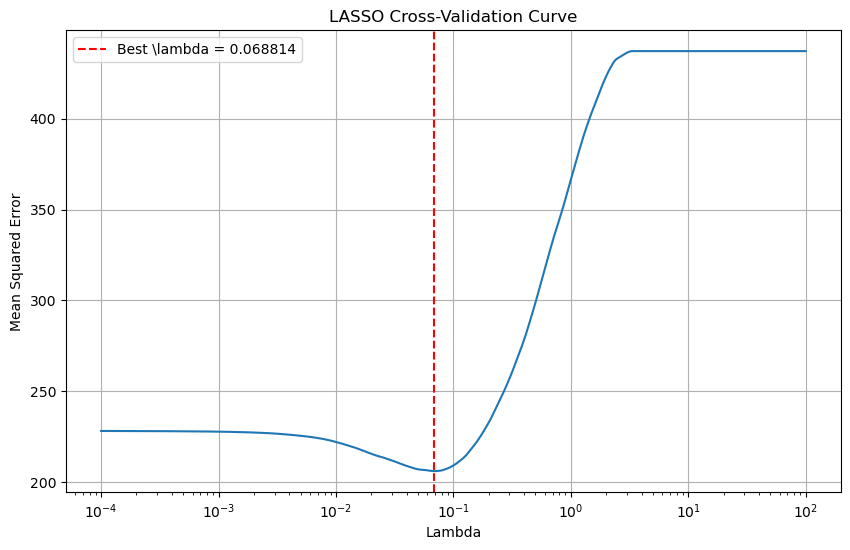

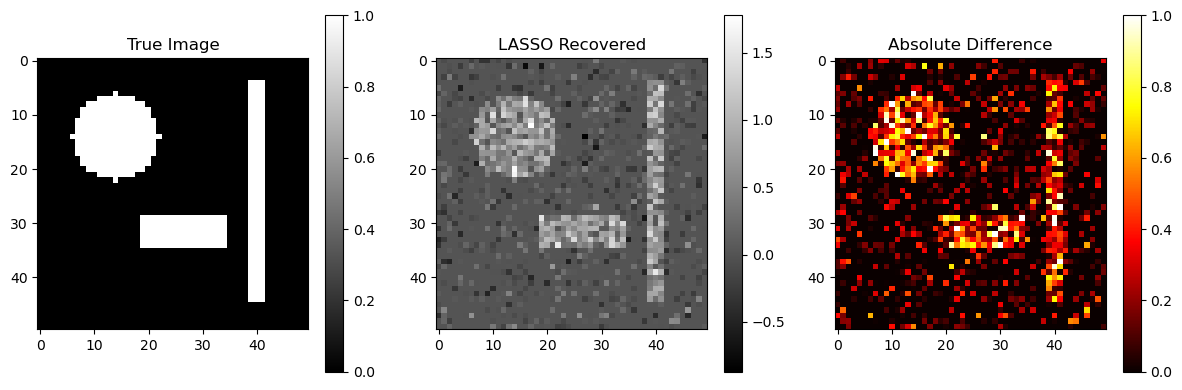

In [56]:
y = A @ true_x + noise

# LASSO with 10-fold CV
lasso_cv = LassoCV(cv=10, alphas=np.logspace(-4, 2, 500), random_state=42)
lasso_cv.fit(A, y)

# Get the best lambda and recovered image
best_lambda_lasso = lasso_cv.alpha_
x_lasso = lasso_cv.coef_
recovered_image_lasso = x_lasso.reshape(50, 50)

print(f"Best lambda (LASSO): {best_lambda_lasso:.6f}")

# Plot cross-validation curve
plt.figure(figsize=(10, 6))
plt.semilogx(lasso_cv.alphas_, np.mean(lasso_cv.mse_path_, axis=1))
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('LASSO Cross-Validation Curve')
plt.axvline(best_lambda_lasso, color='r', linestyle='--', 
            label=f'Best \lambda = {best_lambda_lasso:.6f}')
plt.legend()
plt.grid(True)
plt.show()

# Plot recovered image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(true_image, cmap='gray')
plt.title('True Image')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(recovered_image_lasso, cmap='gray')
plt.title('LASSO Recovered')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.abs(true_image - recovered_image_lasso), cmap='hot')
plt.title('Absolute Difference')
plt.colorbar()
plt.tight_layout()
plt.show()

### Ridge

In [111]:
y = A @ true_x + noise

# ridge with 10-fold CV
ridge_cv = RidgeCV(cv=10, alphas=np.logspace(-4, 3, 50))
ridge_cv.fit(A, y)

# Get the best lambda and recovered image
best_lambda_ridge = ridge_cv.alpha_
x_ridge = ridge_cv.coef_
recovered_image_ridge = x_ridge.reshape(50, 50)

print(f"Best lambda (ridge): {best_lambda_ridge:.6f}")

Best lambda (ridge): 100.000000


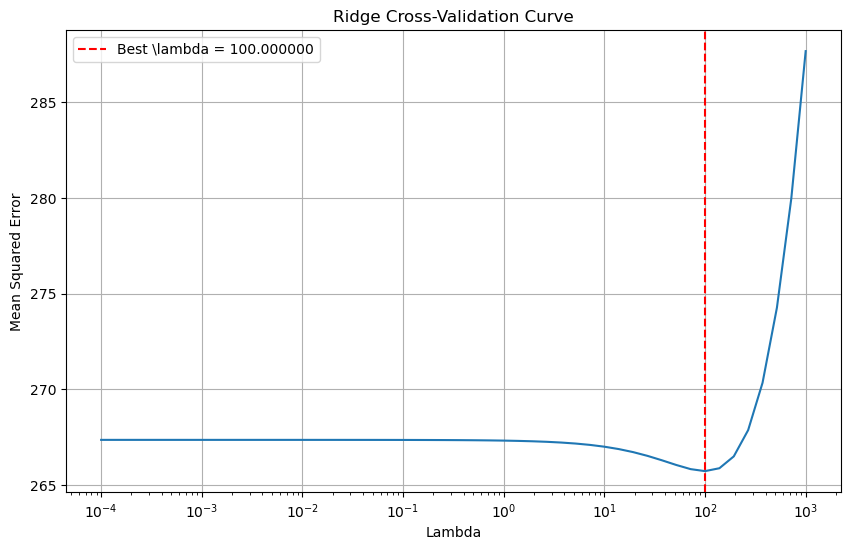

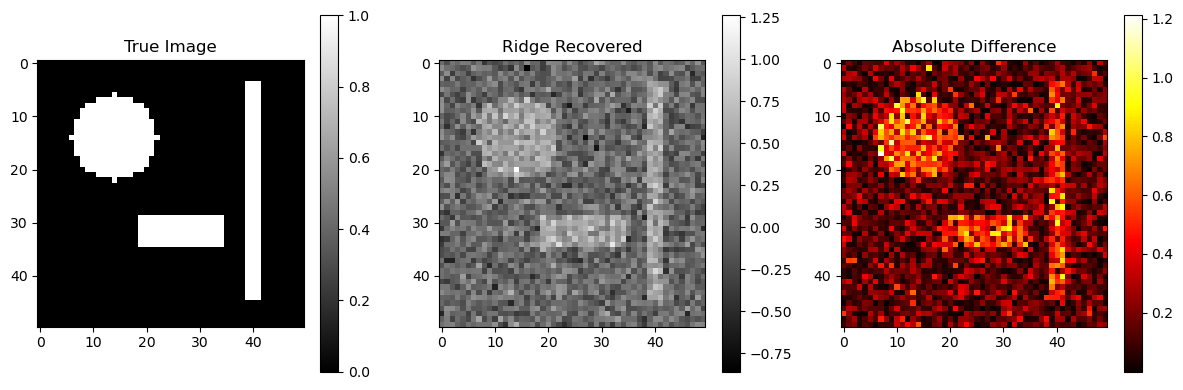

In [112]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

alphas = np.logspace(-4, 3, 100)
cv_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, A, y, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())  # Convert back to positive MSE

# Plot cross-validation curve
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, cv_scores)
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Cross-Validation Curve')
plt.axvline(best_lambda_ridge, color='r', linestyle='--', 
            label=f'Best \lambda = {best_lambda_ridge:.6f}')
plt.legend()
plt.grid(True)
plt.show()

# Plot recovered image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(true_image, cmap='gray')
plt.title('True Image')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(recovered_image_ridge, cmap='gray')
plt.title('Ridge Recovered')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(np.abs(true_image - recovered_image_ridge), cmap='hot')
plt.title('Absolute Difference')
plt.colorbar()

plt.tight_layout()
plt.show()

## Density Estimation — Psychological Experiments

The dataset `n90pol.csv` contains data from 90 students examining the relationship between brain structure and political orientation.

**Variables**
- `amygdala`: residual volume of the amygdala (emotion-related region)
- `acc`: residual volume of the anterior cingulate cortex (decision-making region)
- `orientation`: political orientation score (2 = conservative, 5 = liberal)

We use **histogram** and **kernel density estimation (KDE)** methods for analysis.

**1. Univariate Density Estimation**

Estimate and visualize the distributions of `amygdala` and `acc` using both histograms and 1D KDE with Gaussian kernels.  
Select bandwidth \(h\) using:

$$
h \approx 1.06 \, \hat{\sigma} \, n^{-1/5}
$$

**2. Bivariate Histogram**

Visualize the joint distribution of (`amygdala`, `acc`) using a 2D histogram with suitable bin sizes.

**3. Bivariate KDE**

Estimate the joint density \(p(\text{amygdala}, \text{acc})\) using a 2D Gaussian kernel:

$$
K(x) = \frac{1}{2\pi} e^{-\frac{x_1^2 + x_2^2}{2}}
$$

Display the results as a **heatmap** or **contour plot**.  
Assess whether the two brain regions appear statistically dependent or independent.

**4. Conditional Density Estimation by Political Orientation**

For each orientation level \(c = 2, 3, 4, 5\):

- Estimate \(p(\text{amygdala} \mid \text{orientation} = c)\)
- Estimate \(p(\text{acc} \mid \text{orientation} = c)\)

Use 1D KDE for each subset of data and plot all eight conditional density curves (four for each variable).  
Compute and display conditional sample means for each group.  
This analysis explores whether brain structure differs systematically across political orientations.

---


Bandwidth for amygdala :  0.013973984566878189
Bandwidth for acc :  0.008758179725254514


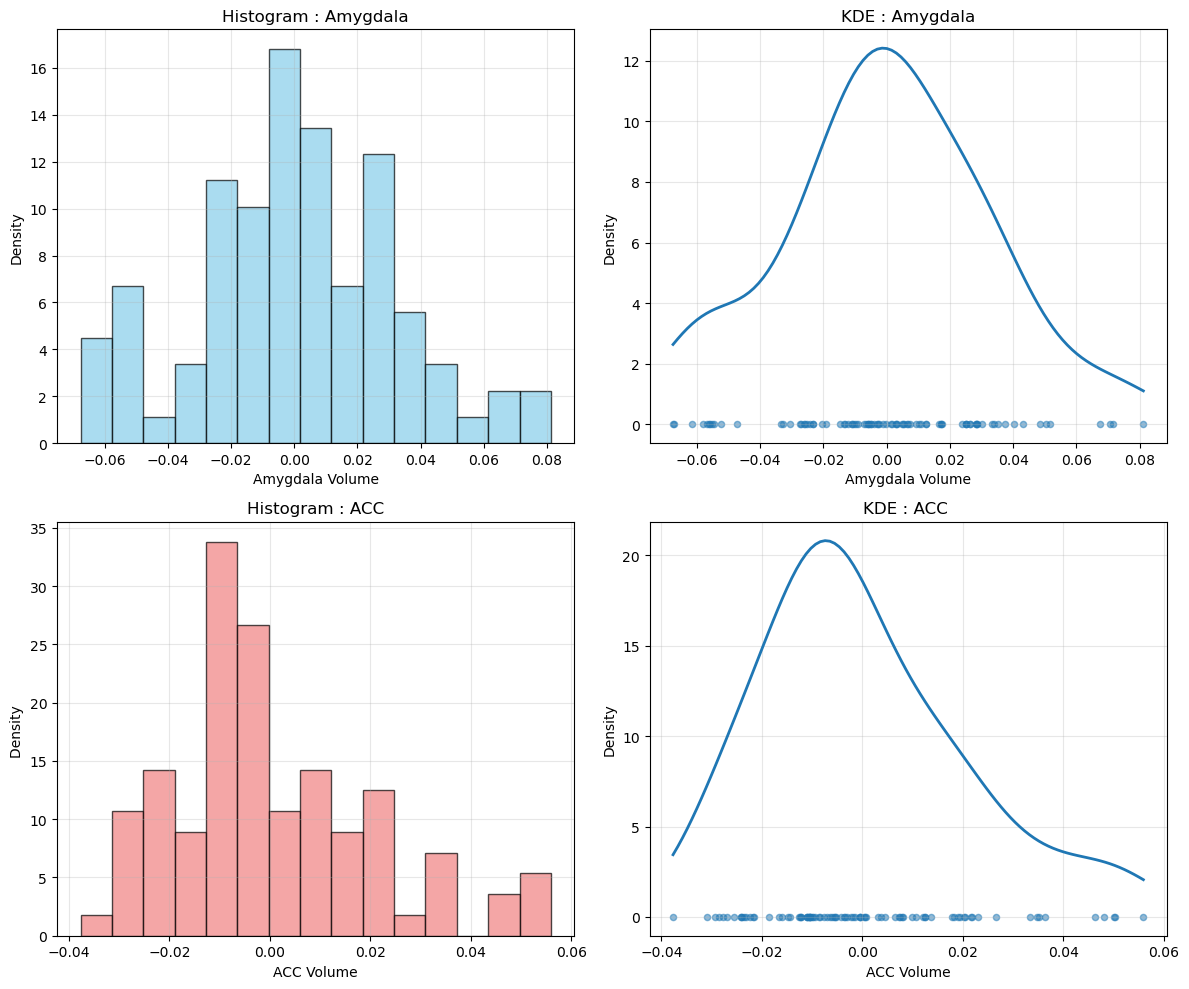

In [63]:
import pandas as pd
import numpy as np
import matplotlib . pyplot as plt
from sklearn . neighbors import KernelDensity
import seaborn as sns

# Load data
data = pd . read_csv ( 'n90pol.csv')
amygdala = data [ 'amygdala']. values
acc = data ['acc']. values
# Rule - of - thumb bandwidth
n = len ( amygdala )
h_amygdala = 1.06 * np . std ( amygdala ) * ( n **( -1/5) )
h_acc = 1.06 * np . std ( acc ) * ( n **( -1/5) )
print ( "Bandwidth for amygdala : ",h_amygdala )
print ( "Bandwidth for acc : ", h_acc )
# 1 D Histogram and KDE for amygdala
fig , axes = plt . subplots (2 , 2 , figsize =(12 , 10) )
# Amygdala histogram
axes [0 ,0]. hist ( amygdala , bins =15 , density = True , alpha =0.7 , color = 'skyblue',edgecolor = 'black')
axes [0 ,0]. set_title ( 'Histogram : Amygdala')
axes [0 ,0]. set_xlabel ( 'Amygdala Volume')
axes [0 ,0]. set_ylabel ( 'Density')
axes [0 ,0]. grid ( True , alpha =0.3)


# Amygdala KDE
kde_amygdala = KernelDensity ( bandwidth = h_amygdala , kernel = 'gaussian')
kde_amygdala . fit ( amygdala . reshape ( -1 , 1) )
x_amygdala = np . linspace ( amygdala . min () , amygdala . max () , 100)
log_dens_amygdala = kde_amygdala . score_samples ( x_amygdala . reshape ( -1 , 1) )
axes[0 ,1].plot( x_amygdala , np . exp ( log_dens_amygdala ) , linewidth =2)
axes [0 ,1]. scatter ( amygdala , np . zeros_like ( amygdala ) , alpha =0.5 , s =20)
axes [0 ,1]. set_title ( 'KDE : Amygdala')
axes [0 ,1]. set_xlabel ( 'Amygdala Volume')
axes [0 ,1]. set_ylabel ( 'Density')
axes [0 ,1]. grid ( True , alpha =0.3)

# ACC histogram
axes [1 ,0]. hist ( acc , bins =15 , density = True , alpha =0.7 , color = 'lightcoral' ,edgecolor = 'black')
axes [1 ,0]. set_title ('Histogram : ACC')
axes [1 ,0]. set_xlabel ( 'ACC Volume')
axes [1 ,0]. set_ylabel ( 'Density ')
axes [1 ,0]. grid ( True , alpha =0.3)

kde_acc = KernelDensity ( bandwidth = h_acc ,  kernel = 'gaussian')
kde_acc . fit ( acc . reshape ( -1 , 1) )
x_acc = np . linspace ( acc . min () , acc . max () , 100)
log_dens_acc = kde_acc . score_samples ( x_acc . reshape ( -1 , 1) )
axes [1 ,1]. plot ( x_acc , np . exp ( log_dens_acc ) , linewidth =2)
axes [1 ,1]. scatter ( acc , np . zeros_like ( acc ) , alpha =0.5 , s =20)
axes [1 ,1]. set_title ( 'KDE : ACC ')
axes [1 ,1]. set_xlabel ( 'ACC Volume')
axes [1 ,1]. set_ylabel ( 'Density')
axes [1 ,1]. grid ( True , alpha =0.3)
plt . tight_layout ()
plt . show ()



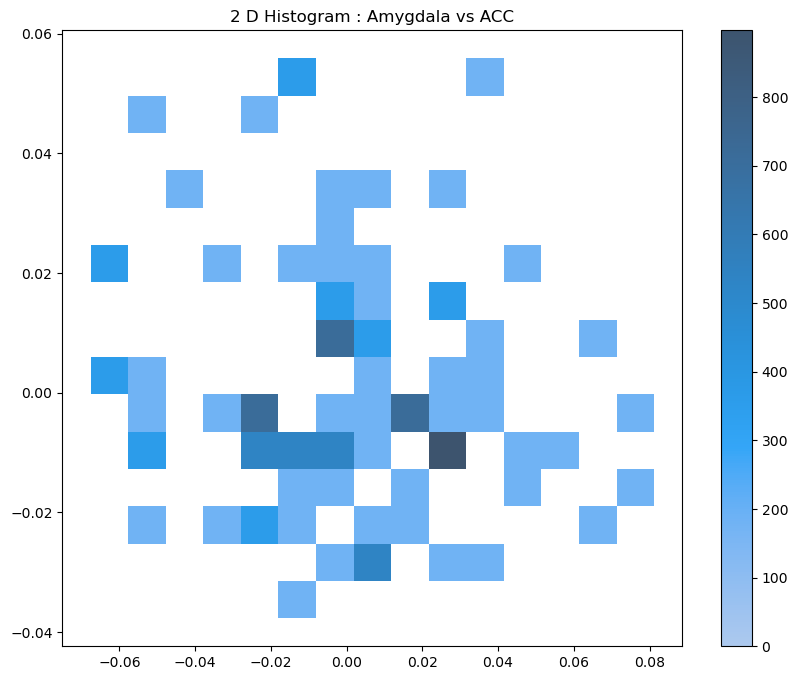

In [64]:
# 2 D Histogram
# plt . figure ( figsize =(10 , 8) )
# plt . hist2d ( amygdala , acc , bins =[12 , 12] , density = True , cmap = 'Blues')
# plt . colorbar ( label = 'Density')
# plt . xlabel ( 'Amygdala Volume')
# plt . ylabel ( 'ACC Volume')
# plt . title ( '2 D Histogram : Amygdala vs ACC')
# plt . grid ( True , alpha =0.3)
# plt . show ()
# Alternative with seaborn
plt . figure ( figsize =(10 , 8) )
sns . histplot ( x = amygdala , y = acc , bins =15 , cbar = True , stat = 'density')
plt . title ( '2 D Histogram : Amygdala vs ACC')
plt . show ()

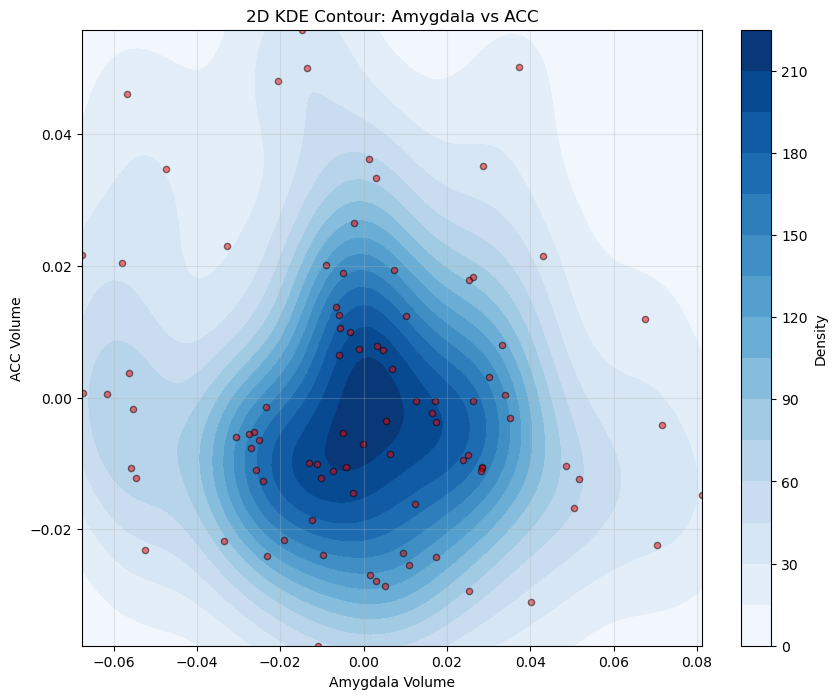

In [67]:
# 2D KDE with Gaussian kernel
xy = np.vstack([amygdala, acc]).T

# Bandwidth for 2D KDE (Silverman’s rule: average of h_amygdala and h_acc, or cross-validation)
h_2d = np.mean([h_amygdala, h_acc])

kde_2d = KernelDensity(bandwidth=h_2d, kernel='gaussian')
kde_2d.fit(xy)

# Grid for evaluation
xgrid = np.linspace(amygdala.min(), amygdala.max(), 100)
ygrid = np.linspace(acc.min(), acc.max(), 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
grid_points = np.vstack([Xgrid.ravel(), Ygrid.ravel()]).T

# Evaluate log density
log_dens_2d = kde_2d.score_samples(grid_points)
Z = np.exp(log_dens_2d).reshape(Xgrid.shape)

# Contour plot
plt.figure(figsize=(10, 8))
plt.contourf(Xgrid, Ygrid, Z, levels=15, cmap="Blues")
plt.colorbar(label="Density")
plt.scatter(amygdala, acc, s=20, alpha=0.5, c="red", edgecolor="k")
plt.title("2D KDE Contour: Amygdala vs ACC")
plt.xlabel("Amygdala Volume")
plt.ylabel("ACC Volume")
plt.grid(alpha=0.3)
plt.show()


In [68]:
from sklearn.feature_selection import mutual_info_regression

# MI estimation
X = amygdala.reshape(-1, 1)
Y = acc
mi = mutual_info_regression(X, Y, discrete_features=False)[0]
print("Estimated Mutual Information:", mi)


Estimated Mutual Information: 0.19924162621557917


In [69]:
from scipy.stats import pearsonr, spearmanr

# Pearson correlation
r, pval = pearsonr(amygdala, acc)
print("Pearson correlation:", r, "p-value:", pval)

Pearson correlation: -0.1284840320498912 p-value: 0.22747925956271203


Conditional Sample Means:
             c = 2     c = 3    c = 4     c = 5
amygdala  0.019062  0.000588 -0.00472 -0.005692
acc      -0.014769  0.001671  0.00131  0.008142


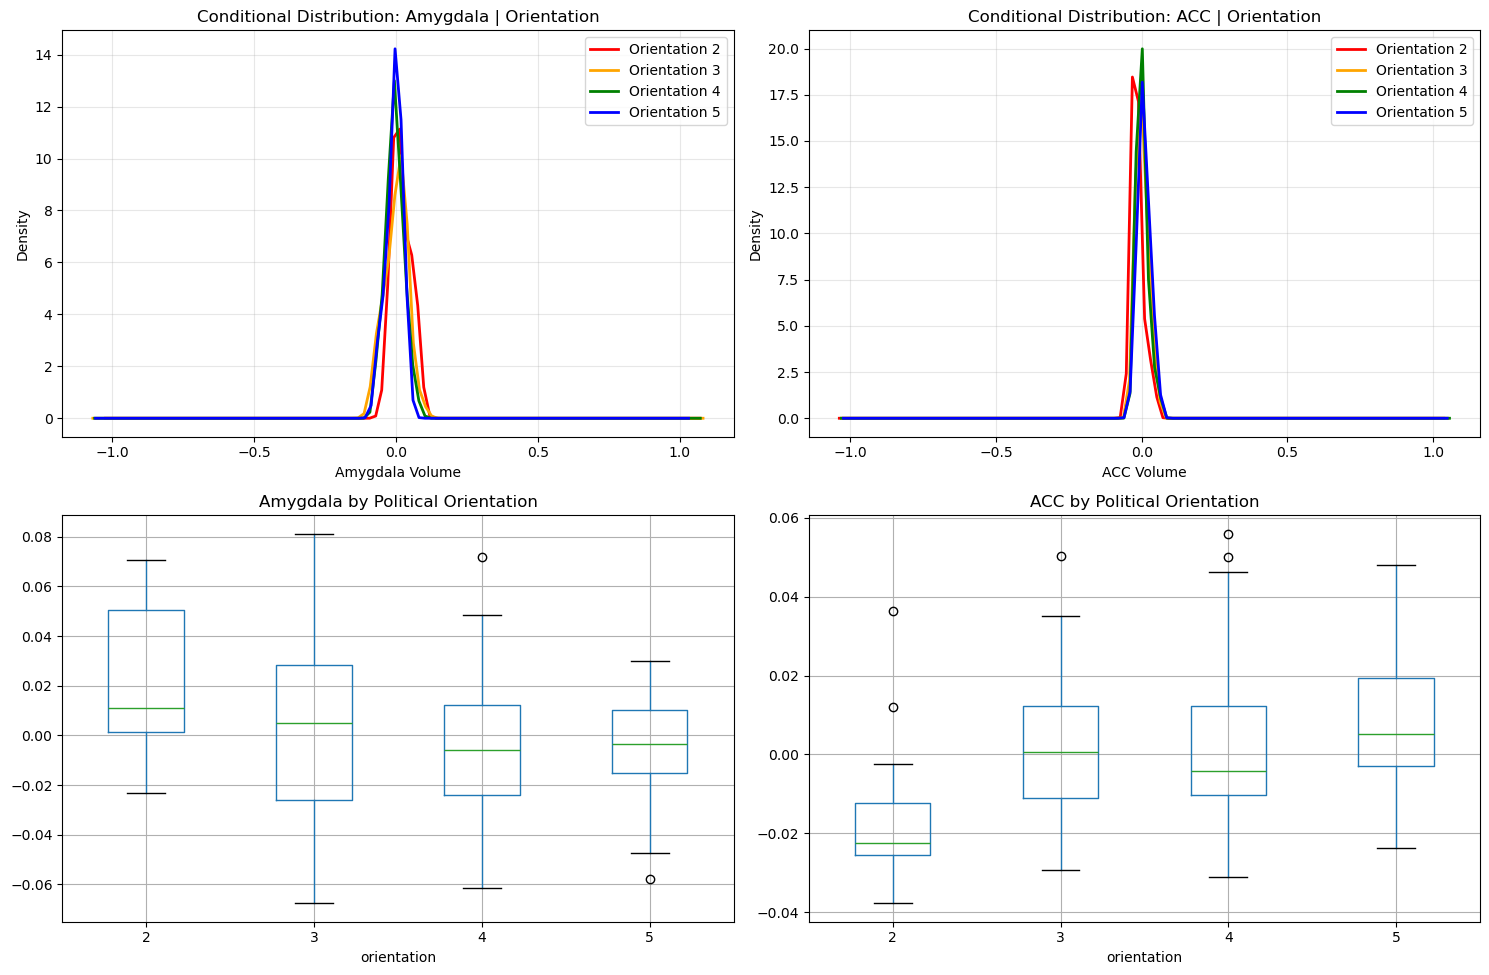


ANOVA Results:
Amygdala: F-statistic = 1.9526, p-value = 0.1272
ACC: F-statistic = 3.2346, p-value = 0.0262

Interpretation (lpha = 0.05):
Amygdala: No significant differences between political orientations
ACC: Significant differences between political orientations


In [65]:
# Conditional distributions by political orientation
orientations = [2, 3, 4, 5]
colors = ['red', 'orange', 'green', 'blue']

# Plot conditional distributions for amygdala
plt.figure(figsize=(15, 10))

# Amygdala conditional distributions
plt.subplot(2, 2, 1)
for i, orient in enumerate(orientations):
    subset = data[data['orientation'] == orient]['amygdala'].values
    if len(subset) > 0:
        # Rule-of-thumb bandwidth for subset
        h_subset = 1.06 * np.std(subset) * (len(subset)**(-1/5))
        
        # Fit KDE
        kde_subset = KernelDensity(bandwidth=h_subset, kernel='gaussian')
        kde_subset.fit(subset.reshape(-1, 1))
        
        # Evaluate KDE
        x_range = np.linspace(subset.min()-1, subset.max()+1, 100)
        log_dens = kde_subset.score_samples(x_range.reshape(-1, 1))
        
        plt.plot(x_range, np.exp(log_dens), color=colors[i], 
                linewidth=2, label=f'Orientation {orient}')

plt.xlabel('Amygdala Volume')
plt.ylabel('Density')
plt.title('Conditional Distribution: Amygdala | Orientation')
plt.legend()
plt.grid(True, alpha=0.3)

# ACC conditional distributions
plt.subplot(2, 2, 2)
for i, orient in enumerate(orientations):
    subset = data[data['orientation'] == orient]['acc'].values
    if len(subset) > 0:
        # Rule-of-thumb bandwidth for subset
        h_subset = 1.06 * np.std(subset) * (len(subset)**(-1/5))
        
        # Fit KDE
        kde_subset = KernelDensity(bandwidth=h_subset, kernel='gaussian')
        kde_subset.fit(subset.reshape(-1, 1))
        
        # Evaluate KDE
        x_range = np.linspace(subset.min()-1, subset.max()+1, 100)
        log_dens = kde_subset.score_samples(x_range.reshape(-1, 1))
        
        plt.plot(x_range, np.exp(log_dens), color=colors[i], 
                linewidth=2, label=f'Orientation {orient}')

plt.xlabel('ACC Volume')
plt.ylabel('Density')
plt.title('Conditional Distribution: ACC | Orientation')
plt.legend()
plt.grid(True, alpha=0.3)

# Calculate conditional sample means
means_table = pd.DataFrame(index=['amygdala', 'acc'], columns=[f'c = {i}' for i in orientations])

for orient in orientations:
    subset_data = data[data['orientation'] == orient]
    means_table.loc['amygdala', f'c = {orient}'] = subset_data['amygdala'].mean()
    means_table.loc['acc', f'c = {orient}'] = subset_data['acc'].mean()

print("Conditional Sample Means:")
print(means_table.round(4))

# Statistical analysis
plt.subplot(2, 2, 3)
data.boxplot(column='amygdala', by='orientation', ax=plt.gca())
plt.title('Amygdala by Political Orientation')
plt.suptitle('')  # Remove default title

plt.subplot(2, 2, 4)
data.boxplot(column='acc', by='orientation', ax=plt.gca())
plt.title('ACC by Political Orientation')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

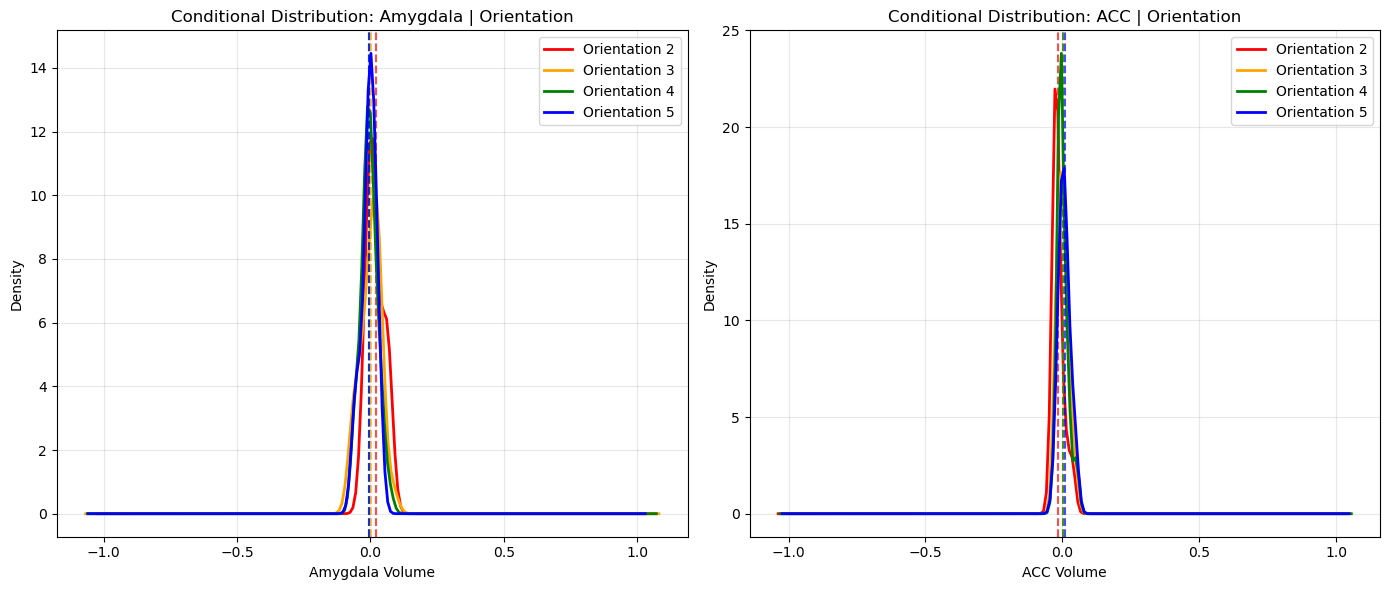

Conditional Sample Means:
             c = 2     c = 3    c = 4     c = 5
amygdala  0.019062  0.000588 -0.00472 -0.005692
acc      -0.014769  0.001671  0.00131  0.008142


In [70]:
# Conditional distributions by political orientation
orientations = [2, 3, 4, 5]
colors = ['red', 'orange', 'green', 'blue']

plt.figure(figsize=(14, 6))

# Amygdala conditional distributions
plt.subplot(1, 2, 1)
for i, orient in enumerate(orientations):
    subset = data[data['orientation'] == orient]['amygdala'].values
    if len(subset) > 0:
        h_subset = 1.06 * np.std(subset) * (len(subset)**(-1/5))
        
        kde_subset = KernelDensity(bandwidth=h_subset, kernel='gaussian')
        kde_subset.fit(subset.reshape(-1, 1))
        
        x_range = np.linspace(subset.min()-1, subset.max()+1, 200)
        log_dens = kde_subset.score_samples(x_range.reshape(-1, 1))
        
        plt.plot(x_range, np.exp(log_dens), color=colors[i], 
                 linewidth=2, label=f'Orientation {orient}')
        
        # Mark conditional mean
        plt.axvline(subset.mean(), color=colors[i], linestyle='--', alpha=0.7)

plt.xlabel('Amygdala Volume')
plt.ylabel('Density')
plt.title('Conditional Distribution: Amygdala | Orientation')
plt.legend()
plt.grid(True, alpha=0.3)

# ACC conditional distributions
plt.subplot(1, 2, 2)
for i, orient in enumerate(orientations):
    subset = data[data['orientation'] == orient]['acc'].values
    if len(subset) > 0:
        h_subset = 1.06 * np.std(subset) * (len(subset)**(-1/5))
        
        kde_subset = KernelDensity(bandwidth=h_subset, kernel='gaussian')
        kde_subset.fit(subset.reshape(-1, 1))
        
        x_range = np.linspace(subset.min()-1, subset.max()+1, 200)
        log_dens = kde_subset.score_samples(x_range.reshape(-1, 1))
        
        plt.plot(x_range, np.exp(log_dens), color=colors[i], 
                 linewidth=2, label=f'Orientation {orient}')
        
        # Mark conditional mean
        plt.axvline(subset.mean(), color=colors[i], linestyle='--', alpha=0.7)

plt.xlabel('ACC Volume')
plt.ylabel('Density')
plt.title('Conditional Distribution: ACC | Orientation')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Conditional sample means
means_table = pd.DataFrame(index=['amygdala', 'acc'], 
                           columns=[f'c = {i}' for i in orientations])

for orient in orientations:
    subset_data = data[data['orientation'] == orient]
    means_table.loc['amygdala', f'c = {orient}'] = subset_data['amygdala'].mean()
    means_table.loc['acc', f'c = {orient}'] = subset_data['acc'].mean()

print("Conditional Sample Means:")
print(means_table.round(4))



## Spline and Smoothing Spline

This section investigates spline fitting for three equally spaced data points \((x_0, y_0), (x_1, y_1), (x_2, y_2)\) with spacing \(h = x_{i+1} - x_i\).

**1. Exact Interpolation Spline**

Construct a spline \(s(x)\) that passes exactly through all three data points, parameterized by its second derivative with boundary conditions:

$$
s''(x_0) = s''(x_2) = 0
$$

Express \(s(x)\) explicitly in terms of \(x_0, x_1, x_2, y_0, y_1, y_2\).

**2. Smoothing Spline with Regularization**

Introduce noise and relax the interpolation condition. Fit \(s(x)\) by minimizing:

$$
\min_s \sum_{i=0}^{2} (y_i - f_i)^2 + \lambda \int_{x_0}^{x_2} [s''(x)]^2 dx, \quad f_i = s(x_i)
$$

For \(\lambda = 1\), derive the linear system or expression that determines spline parameters.  
This illustrates the **bias-variance trade-off** in smoothing splines.

---

Fitted model: Y = 7.3841 + 0.0213X
R-squared: 0.6862


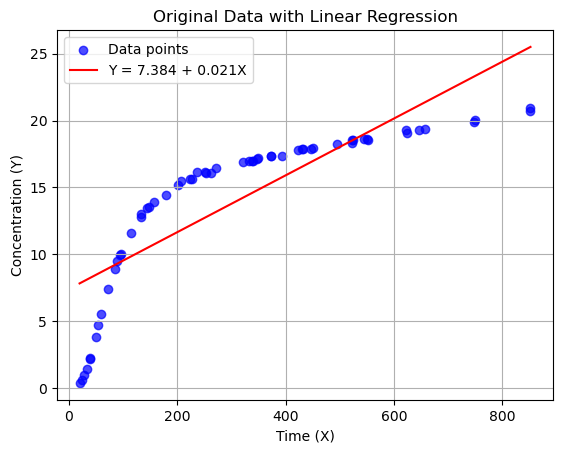

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize_scalar
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

df_space = pd.read_csv('copper-new.txt', sep=" ", header = None)

data = []
for i in range(len(df_space)):
    temp = []
    for j in range(8):
        if ~np.isnan(df_space.iloc[i,j].item()):
            temp.append(df_space.iloc[i,j].item())
    data.append(temp)

act_data = pd.DataFrame(data, columns=['y','x'])

i = np.arange(0,59,1)
x = np.array(act_data['x'])
y = np.array(act_data['y'])

X_matrix = np.column_stack([np.ones(len(x)), x])
beta_hat = np.linalg.inv(X_matrix.T @ X_matrix) @ X_matrix.T @ y
y_fitted = X_matrix @ beta_hat

print(f"Fitted model: Y = {beta_hat[0]:.4f} + {beta_hat[1]:.4f}X")

# Scatter plot with regression line
# plt.figure(figsize=(15, 12))

# plt.subplot(2, 3, 1)
plt.scatter(x, y, color='blue', alpha=0.7, label='Data points')
x_line = np.linspace(min(x), max(x), 100)
y_line = beta_hat[0] + beta_hat[1] * x_line
plt.plot(x_line, y_line, 'r-', label=f'Y = {beta_hat[0]:.3f} + {beta_hat[1]:.3f}X')
plt.xlabel('Temp (X)')
plt.ylabel('Concentration (Y)')
plt.title('Original Data with Linear Regression')
plt.legend()
plt.grid(True)

# Calculate R-squared
y_mean = np.mean(y)
ss_tot = np.sum((y - y_mean)**2)
ss_res = np.sum((y - y_fitted)**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.4f}")

Linear fit: Y = 7.384127 + 0.021283 X
Linear RMSE on all data: 3.243562
Selected lambda by 5-fold CV: 2.512e-02
Spline RMSE on all data (lambda=2.512e-02): 0.075016
Prediction at x=400.0: Linear = 15.897385, Spline = 17.528050


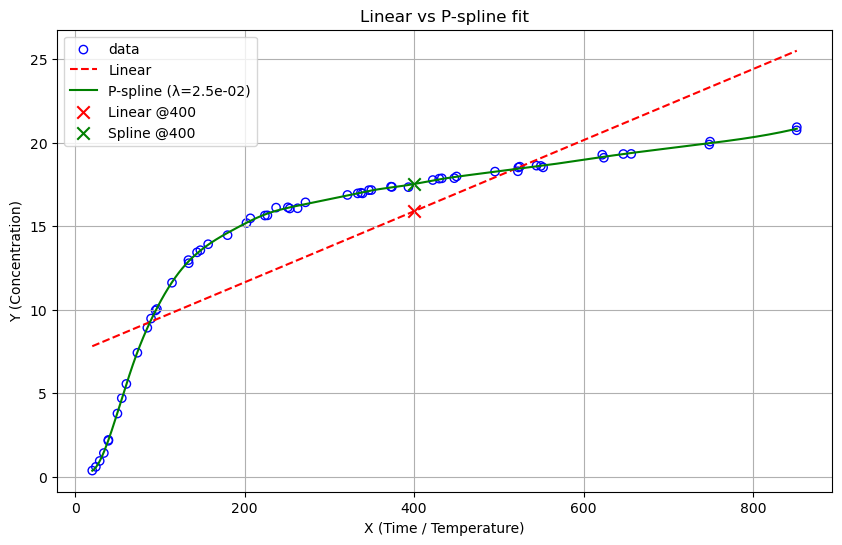


Summary:
 - Linear RMSE: 3.243562
 - P-spline RMSE (λ chosen by CV): 0.075016
 - Prediction at x=400: Linear=15.897385, P-spline=17.528050


In [57]:
import numpy as np
import pandas as pd
from scipy.interpolate import BSpline
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# -------------------------
# Load data (your code)
# -------------------------
df_space = pd.read_csv('copper-new.txt', sep=" ", header=None)

data = []
for i in range(len(df_space)):
    temp = []
    for j in range(8):
        # keep same behavior as your snippet
        if ~np.isnan(df_space.iloc[i, j].item()):
            temp.append(df_space.iloc[i, j].item())
    data.append(temp)

act_data = pd.DataFrame(data, columns=['y', 'x'])
x = np.array(act_data['x'])
y = np.array(act_data['y'])

# Sort by x (helpful for spline plotting & CV stability)
order = np.argsort(x)
x = x[order]
y = y[order]

# -------------------------
# Linear baseline
# -------------------------
X_lin = np.column_stack([np.ones(len(x)), x])
beta_hat = np.linalg.inv(X_lin.T @ X_lin) @ X_lin.T @ y
y_lin_fitted = X_lin @ beta_hat
rmse_lin = np.sqrt(np.mean((y - y_lin_fitted)**2))
print(f"Linear fit: Y = {beta_hat[0]:.6f} + {beta_hat[1]:.6f} X")
print(f"Linear RMSE on all data: {rmse_lin:.6f}")

# -------------------------
# P-spline (B-spline basis + 2nd-diff penalty)
# -------------------------
def build_bspline_basis(x, n_internal_knots=12, degree=3):
    """Return basis matrix B (n x m), knot vector t, degree k."""
    x_min, x_max = x.min(), x.max()
    # internal knots at quantiles
    if n_internal_knots > 0:
        internal_knots = np.quantile(x, np.linspace(0, 1, n_internal_knots+2)[1:-1])
        # ensure strictly inside bounds
        internal_knots = np.clip(internal_knots, x_min + 1e-8, x_max - 1e-8)
    else:
        internal_knots = np.array([])
    k = degree
    # knot vector with boundary repetition k+1
    t = np.concatenate((
        np.repeat(x_min, k+1),
        internal_knots,
        np.repeat(x_max, k+1)
    ))
    m = len(t) - k - 1  # number of basis functions
    # Build basis columns by evaluating each basis BSpline with coefficient vector e_i
    B = np.empty((len(x), m))
    for i in range(m):
        c = np.zeros(m)
        c[i] = 1.0
        spline = BSpline(t, c, k, extrapolate=True)
        B[:, i] = spline(x)
    return B, t, k

def build_second_diff_penalty(m):
    """Return D such that penalty is ||D c||^2 = ||second-differences||^2."""
    # D is (m-2) x m, each row i has [1, -2, 1] at columns i,i+1,i+2
    if m < 3:
        return np.zeros((0, m))
    D = np.zeros((m-2, m))
    for i in range(m-2):
        D[i, i]   = 1.0
        D[i, i+1] = -2.0
        D[i, i+2] = 1.0
    return D

def fit_pspline(B, y, lam, D):
    """Solve (B^T B + lam * D^T D) c = B^T y"""
    BtB = B.T @ B
    BtY = B.T @ y
    penalty = lam * (D.T @ D) if D.shape[0] > 0 else 0.0
    A = BtB + penalty
    c = np.linalg.solve(A, BtY)
    y_hat = B @ c
    return c, y_hat

# Build basis
n_internal_knots = max(8, min(20, len(x)//3))  # heuristic default
B, t, k = build_bspline_basis(x, n_internal_knots=n_internal_knots, degree=3)
m = B.shape[1]
D = build_second_diff_penalty(m)

# -------------------------
# Cross-validation to pick lambda
# -------------------------
def cv_lambda(B, y, D, lambdas, n_splits=5, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    mean_mse = []
    for lam in lambdas:
        mses = []
        for train_idx, test_idx in kf.split(B):
            B_tr, y_tr = B[train_idx], y[train_idx]
            B_te, y_te = B[test_idx], y[test_idx]
            # fit on train
            c_tr, _ = fit_pspline(B_tr, y_tr, lam, D)
            # predict on test
            y_pred = B_te @ c_tr
            mses.append(np.mean((y_te - y_pred)**2))
        mean_mse.append(np.mean(mses))
    return np.array(mean_mse)

# grid of lambdas (log-spaced)
lambdas = np.logspace(-8, 8, 41)
cv_mse = cv_lambda(B, y, D, lambdas, n_splits=5)
best_idx = np.argmin(cv_mse)
best_lambda = lambdas[best_idx]
print(f"Selected lambda by 5-fold CV: {best_lambda:.3e}")

# Fit final with best lambda
c_hat, y_spline_fitted = fit_pspline(B, y, best_lambda, D)
rmse_spline = np.sqrt(np.mean((y - y_spline_fitted)**2))
print(f"Spline RMSE on all data (lambda={best_lambda:.3e}): {rmse_spline:.6f}")

# -------------------------
# Predict at x = 400
# -------------------------
x_pred = 400.0
# Linear predict:
y_lin_pred = beta_hat[0] + beta_hat[1] * x_pred

# Spline predict:
# Build basis for x_pred (evaluate same B-spline basis at new x)
spline_basis_pred = []
m = B.shape[1]
for i in range(m):
    c = np.zeros(m)
    c[i] = 1.0
    spline = BSpline(t, c, k, extrapolate=True)
    spline_basis_pred.append(spline(x_pred))
spline_basis_pred = np.array(spline_basis_pred)
y_spline_pred = spline_basis_pred @ c_hat

print(f"Prediction at x={x_pred}: Linear = {y_lin_pred:.6f}, Spline = {y_spline_pred:.6f}")

# Warn if x_pred is outside training range
if not (x.min() <= x_pred <= x.max()):
    print("WARNING: x_pred is outside the training data range. Spline extrapolation is unreliable; linear extrapolation may be more stable.")

# -------------------------
# Plots
# -------------------------
plt.figure(figsize=(10,6))
plt.scatter(x, y, facecolors='none', edgecolors='b', label='data')
# linear line
xs = np.linspace(x.min(), x.max(), 400)
ys_lin = beta_hat[0] + beta_hat[1]*xs
plt.plot(xs, ys_lin, 'r--', label='Linear')

# spline curve across range
# evaluate spline across a dense grid
B_grid = np.column_stack([BSpline(t, np.eye(m)[:,j], k)(xs) for j in range(m)])
ys_spline_grid = B_grid @ c_hat
plt.plot(xs, ys_spline_grid, 'g-', label=f'P-spline (λ={best_lambda:.1e})')

# mark predictions
plt.scatter([x_pred], [y_lin_pred], c='red', marker='x', s=80, label='Linear @400')
plt.scatter([x_pred], [y_spline_pred], c='green', marker='x', s=80, label='Spline @400')

plt.xlabel('X (Time / Temperature)')
plt.ylabel('Y (Concentration)')
plt.legend()
plt.title('Linear vs P-spline fit')
plt.grid(True)
plt.show()

# -------------------------
# Report
# -------------------------
print("\nSummary:")
print(f" - Linear RMSE: {rmse_lin:.6f}")
print(f" - P-spline RMSE (λ chosen by CV): {rmse_spline:.6f}")
print(f" - Prediction at x=400: Linear={y_lin_pred:.6f}, P-spline={y_spline_pred:.6f}")




## Nonlinear Regression using Splines

We analyze the relationship between **temperature** and the **coefficient of thermal expansion** of copper using data from `copper-new.txt`.

**1. Linear Regression**

Fit a linear model relating the coefficient of thermal expansion \(y\) to temperature \(x\).  
Report the fitted model parameters and fitting error.

**2. Nonlinear Regression using Cubic Splines**

Fit a nonlinear model using **cubic splines** across all data points.  
Use **cross-validation** to choose the smoothness parameter \(\lambda\).  
Report the fitted model and fitting error.  
Predict the coefficient of thermal expansion at **400 K** for both models and compare which gives a more accurate estimate.

---

Best lambda (CV): 0.00791234
Spline MSE: 0.0054, R^2: 0.9998
Prediction at 400K (Spline): 17.4948


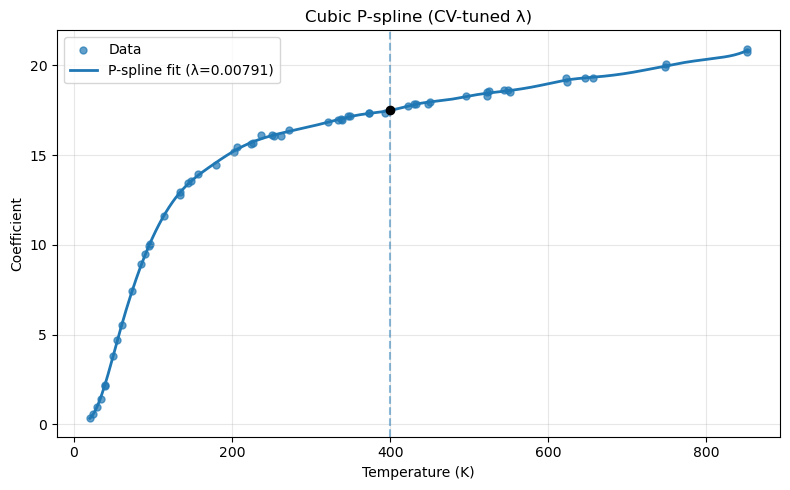

In [74]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from sklearn.model_selection import KFold

# ---- data (robust loader for the space-formatted file) ----
df = pd.read_csv('copper-new.txt', sep=r'\s+', header=None)

arr = df.to_numpy().ravel()
arr = arr[~np.isnan(arr)]
assert arr.size % 2 == 0, "Unexpected file format: flattened length is not even."

pairs = arr.reshape(-1, 2).astype(float)  # columns: [y, x]
y = pairs[:, 0]
x = pairs[:, 1]

# sort by x (good for plotting/splines)
o = np.argsort(x)
x, y = x[o], y[o]

# ---- cubic B-spline basis ----
def knots_open(x, m=25, k=3):
    xmin, xmax = x.min(), x.max()
    r = max(m - k - 1, 0)
    interior = np.linspace(xmin, xmax, r + 2)[1:-1] if r > 0 else []
    return np.r_[ [xmin]*(k+1), interior, [xmax]*(k+1) ]

def design(xv, t, k=3):
    m = len(t) - k - 1
    Phi = np.zeros((len(xv), m))
    for j in range(m):
        c = np.zeros(m); c[j] = 1
        Phi[:, j] = BSpline(t, c, k)(xv)
    return Phi

k, m = 3, 25
t   = knots_open(x, m, k)
Phi = design(x, t, k)

# ---- roughness penalty (second differences) ----
def D2(m):
    D = np.zeros((m-2, m))
    for i in range(m-2): D[i, i:i+3] = [1, -2, 1]
    return D
R = D2(Phi.shape[1]).T @ D2(Phi.shape[1])

# ---- 10-fold CV for lambda ----
lams = np.logspace(-6, 4, 60)
kf = KFold(10, shuffle=True, random_state=42)
def fit(Phi, y, lam): return np.linalg.solve(Phi.T@Phi + lam*R, Phi.T@y)

cv = []
for lam in lams:
    errs = []
    for tr, va in kf.split(Phi):
        c = fit(Phi[tr], y[tr], lam)
        yhat = Phi[va] @ c
        errs.append(np.mean((y[va] - yhat)**2))
    cv.append(np.mean(errs))
best_lam = lams[np.argmin(cv)]
print(f"Best lambda (CV): {best_lam:.6g}")

# ---- refit, metrics, prediction @ 400K ----
c_hat   = fit(Phi, y, best_lam)
y_hat   = Phi @ c_hat
mse     = np.mean((y - y_hat)**2)
r2      = 1 - np.sum((y - y_hat)**2)/np.sum((y - y.mean())**2)
x0      = np.array([400.0])
y_400   = design(x0, t, k) @ c_hat
print(f"Spline MSE: {mse:.4f}, R^2: {r2:.4f}")
print(f"Prediction at 400K (Spline): {float(y_400):.4f}")

# (optional) linear 400K using your part-1 beta_hat
# beta0, beta1 = beta_hat
# print(f"Prediction at 400K (Linear): {beta0 + beta1*400:.4f}")

# ---- plot ----
xx = np.linspace(x.min(), x.max(), 400)
yy = design(xx, t, k) @ c_hat
plt.figure(figsize=(8,5))
plt.scatter(x, y, s=25, alpha=0.7, label='Data')
plt.plot(xx, yy, lw=2, label=f'P-spline fit (λ={best_lam:.3g})')
plt.axvline(400, ls='--', alpha=0.5); plt.scatter([400],[y_400], c='k', zorder=5)
plt.xlabel('Temperature (K)'); plt.ylabel('Coefficient'); plt.title('Cubic P-spline (CV-tuned λ)')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

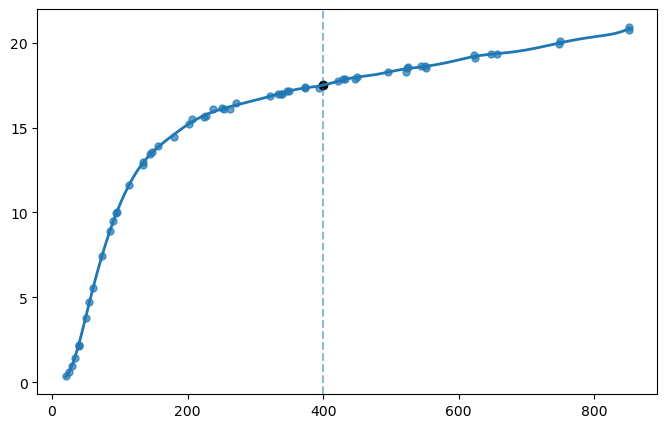

0.007912342618981319 0.005448110716748165 0.9998374922524607 17.494792162751107


In [75]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from sklearn.model_selection import KFold

df = pd.read_csv('copper-new.txt', sep=r'\s+', header=None)
arr = df.to_numpy().ravel()
arr = arr[~np.isnan(arr)]
y, x = arr.reshape(-1, 2)[:,0], arr.reshape(-1, 2)[:,1]
x, y = x[np.argsort(x)], y[np.argsort(x)]

def knots_open(x, m=25, k=3):
    xmin, xmax = x.min(), x.max()
    r = max(m-k-1,0)
    interior = np.linspace(xmin, xmax, r+2)[1:-1] if r>0 else []
    return np.r_[ [xmin]*(k+1), interior, [xmax]*(k+1) ]

def design(xv, t, k=3):
    m = len(t)-k-1
    Phi = np.zeros((len(xv), m))
    for j in range(m):
        c = np.zeros(m); c[j]=1
        Phi[:,j] = BSpline(t,c,k)(xv)
    return Phi

def D2(m):
    D = np.zeros((m-2,m))
    for i in range(m-2): D[i,i:i+3]=[1,-2,1]
    return D

def fit(Phi,y,lam): return np.linalg.solve(Phi.T@Phi + lam*R, Phi.T@y)

k,m = 3,25
t = knots_open(x,m,k)
Phi = design(x,t,k)
R = D2(Phi.shape[1]).T @ D2(Phi.shape[1])

lams = np.logspace(-6,4,60)
kf = KFold(10, shuffle=True, random_state=42)
cv=[]
for lam in lams:
    errs=[]
    for tr,va in kf.split(Phi):
        c = fit(Phi[tr], y[tr], lam)
        yhat = Phi[va] @ c
        errs.append(np.mean((y[va]-yhat)**2))
    cv.append(np.mean(errs))

best_lam = lams[np.argmin(cv)]
c_hat = fit(Phi,y,best_lam)
y_hat = Phi @ c_hat
mse = np.mean((y - y_hat)**2)
r2 = 1 - np.sum((y - y_hat)**2)/np.sum((y - y.mean())**2)
x0 = np.array([400])
y_400 = design(x0,t,k) @ c_hat

xx = np.linspace(x.min(),x.max(),400)
yy = design(xx,t,k) @ c_hat
plt.figure(figsize=(8,5))
plt.scatter(x,y,s=25,alpha=0.7)
plt.plot(xx,yy,lw=2)
plt.scatter([400],[y_400],c='k')
plt.axvline(400,ls='--',alpha=0.5)
plt.show()
print(best_lam,mse,r2,float(y_400))
